## Predicting Dallas Crimes
<br>AI Capstone 2020
<br>Ksenia Luu


In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#jupyter display options
pd.set_option('display.notebook_repr_html', True) 
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

# Plot Options
plt.style.use('seaborn')
plt.rc('font', size=14)
plt.rc('figure', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('axes', titlesize=14)

### Import and Clean Data 
https://www.dallasopendata.com/Public-Safety/Police-Incident-location-and-pertinent-information/v3r6-776m

In [3]:
df = pd.read_csv('Police_Incidents.csv',low_memory=False)
df_copy = df.copy() 

In [4]:
print(df.shape)
df.info()

(631496, 100)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631496 entries, 0 to 631495
Data columns (total 100 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   Incident Number w/year                     631496 non-null  object 
 1   Year of Incident                           631496 non-null  int64  
 2   Service Number ID                          631496 non-null  object 
 3   Watch                                      631496 non-null  int64  
 4   Call (911) Problem                         618147 non-null  object 
 5   Type of Incident                           631496 non-null  object 
 6   Type  Location                             630523 non-null  object 
 7   Type of Property                           149980 non-null  object 
 8   Incident Address                           628554 non-null  object 
 9   Apartment Number                           134795 non-null  object

In [5]:
df=df.sort_values(by=['Date1 of Occurrence'])

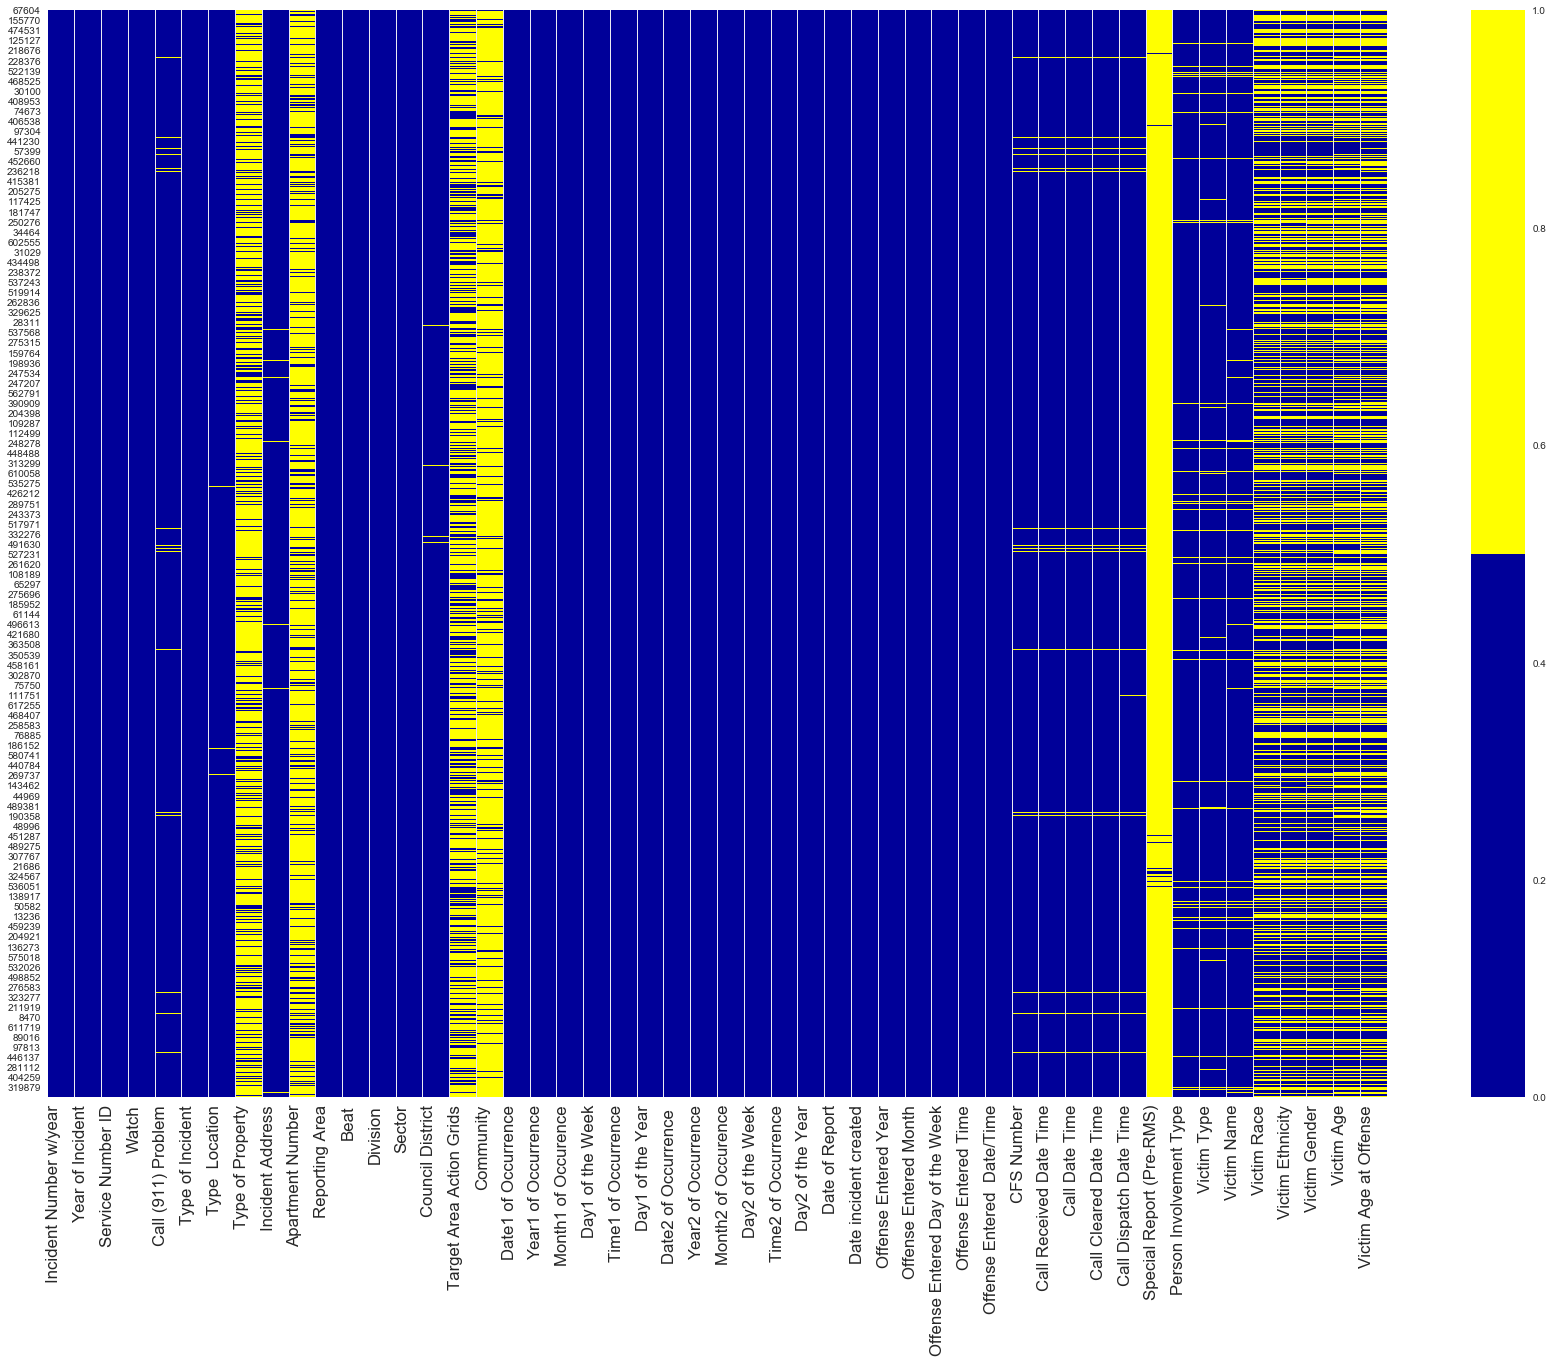

In [6]:
# visual for missing values by row/column
cols = df.columns[:50] # first 50 columns
colors = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
plt.subplots(figsize=(30,20))
plt.xticks(rotation=45,fontsize='large',horizontalalignment='right')
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colors))

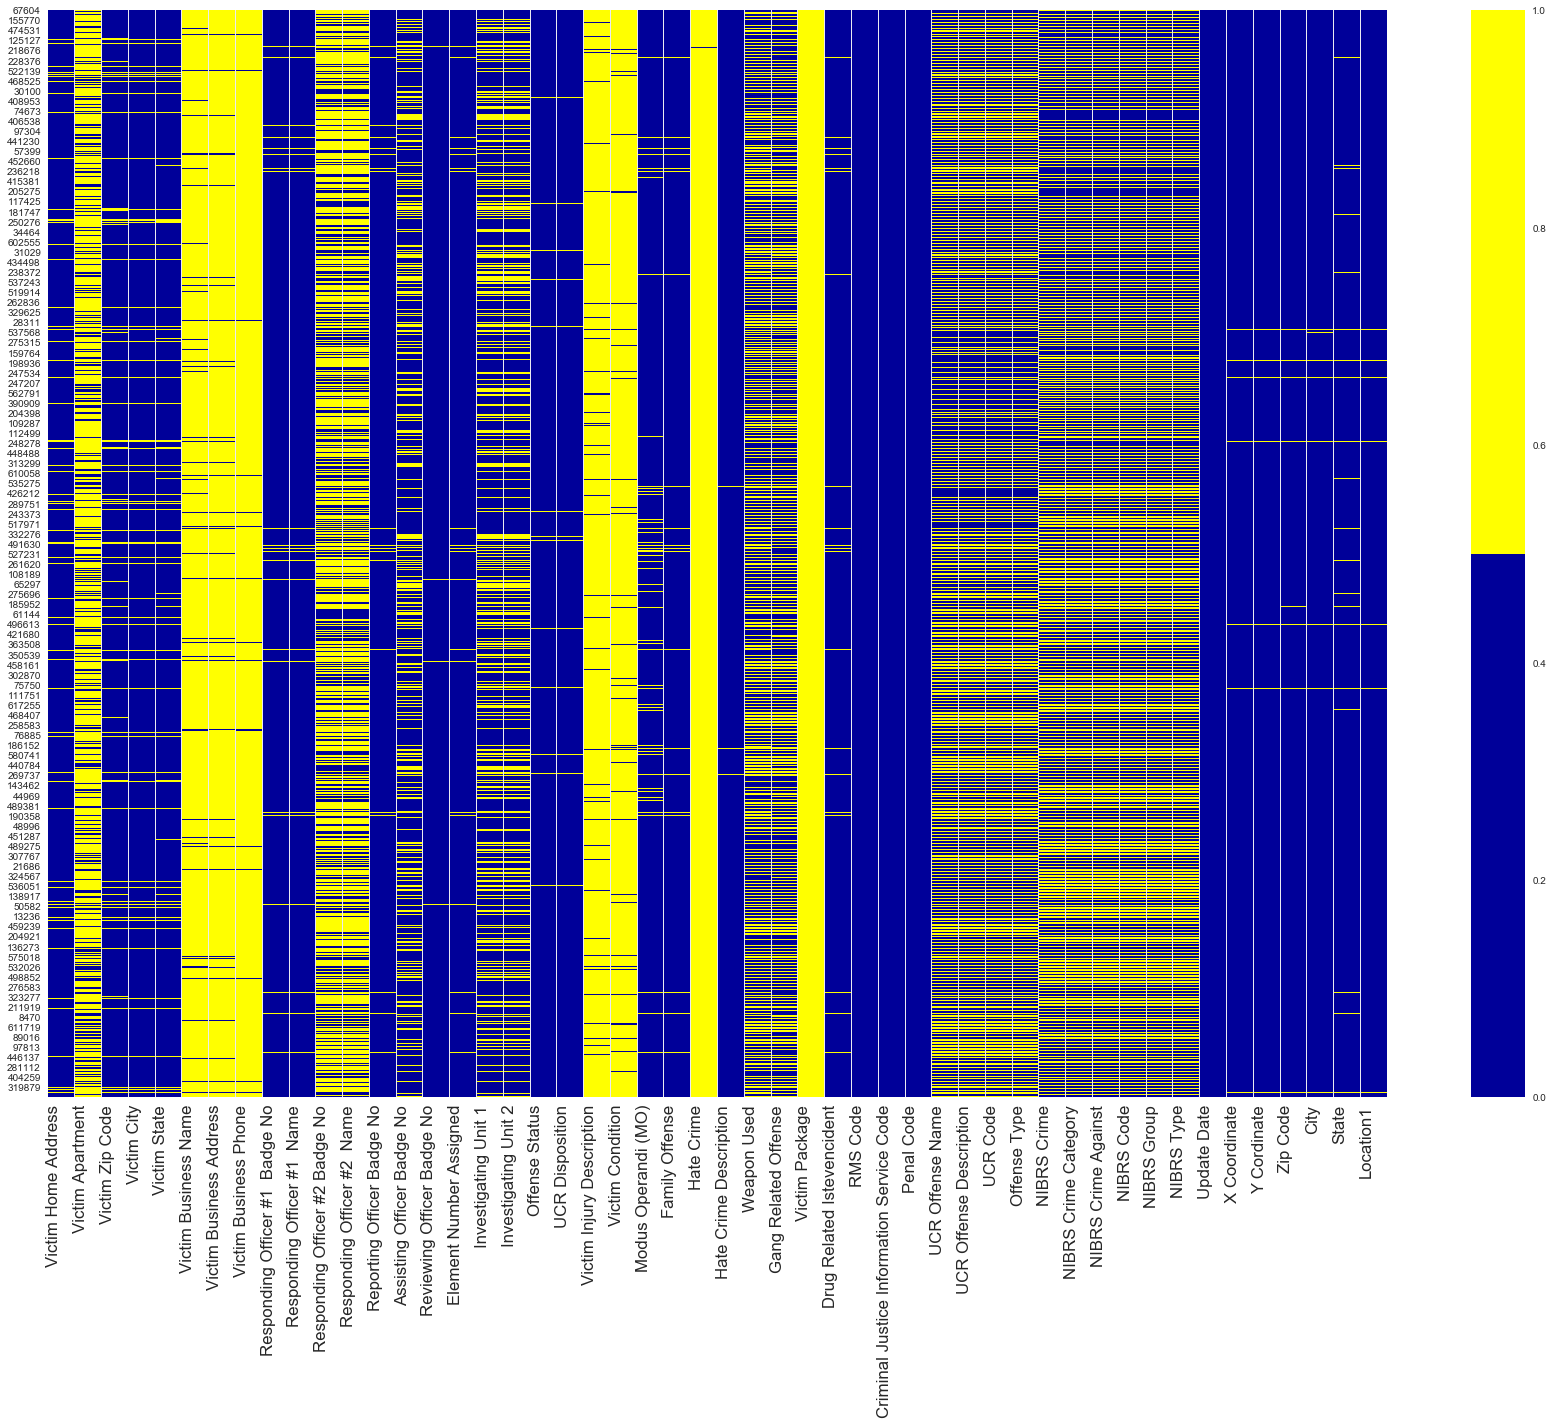

In [7]:
cols = df.columns[-50:] # first 50 columns
colors = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
plt.subplots(figsize=(30,20))
plt.xticks(rotation=45,fontsize='large',horizontalalignment='right')
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colors))

In [6]:
# clean up column names
df.columns = df.columns.str.strip().str.lower().str.replace('  ',' ').str.replace('/','_').str.replace('#','').str.replace('-','_').str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

# lower call columns values
#df = df.astype(str).apply(lambda x: x.str.lower())

### Tagging violent crimes 
https://www.dallasjustice.com/practice-areas/crimes-of-violence/

In [7]:
# crime types are within 4 columns/ check if there are any nulls between all 4
df[ df.loc[ :,['ucr_offense_name','ucr_offense_description','nibrs_crime','nibrs_crime_category'] ].isnull().sum(axis=1) == 4]


Empty DataFrame
Columns: [incident_number_w_year, year_of_incident, service_number_id, watch, call_911_problem, type_of_incident, type_location, type_of_property, incident_address, apartment_number, reporting_area, beat, division, sector, council_district, target_area_action_grids, community, date1_of_occurrence, year1_of_occurrence, month1_of_occurence, day1_of_the_week, time1_of_occurrence, day1_of_the_year, date2_of_occurrence, year2_of_occurrence, month2_of_occurence, day2_of_the_week, time2_of_occurrence, day2_of_the_year, date_of_report, date_incident_created, offense_entered_year, offense_entered_month, offense_entered_day_of_the_week, offense_entered_time, offense_entered_date_time, cfs_number, call_received_date_time, call_date_time, call_cleared_date_time, call_dispatch_date_time, special_report_pre_rms, person_involvement_type, victim_type, victim_name, victim_race, victim_ethnicity, victim_gender, victim_age, victim_age_at_offense, victim_home_address, victim_apartment, victim_zip_code, victim_city, victim_state, victim_business_name, victim_business_address, victim_business_phone, responding_officer_1_badge_no, responding_officer_1_name, responding_officer_2_badge_no, responding_officer_2_name, reporting_officer_badge_no, assisting_officer_badge_no, reviewing_officer_badge_no, element_number_assigned, investigating_unit_1, investigating_unit_2, offense_status, ucr_disposition, victim_injury_description, victim_condition, modus_operandi_mo, family_offense, hate_crime, hate_crime_description, weapon_used, gang_related_offense, victim_package, drug_related_istevencident, rms_code, criminal_justice_information_service_code, penal_code, ucr_offense_name, ucr_offense_description, ucr_code, offense_type, nibrs_crime, nibrs_crime_category, nibrs_crime_against, nibrs_code, nibrs_group, nibrs_type, update_date, x_coordinate, y_cordinate, zip_code, city, state, location1]
Index: []

In [8]:
df.columns

Index(['incident_number_w_year', 'year_of_incident', 'service_number_id',
       'watch', 'call_911_problem', 'type_of_incident', 'type_location',
       'type_of_property', 'incident_address', 'apartment_number',
       'reporting_area', 'beat', 'division', 'sector', 'council_district',
       'target_area_action_grids', 'community', 'date1_of_occurrence',
       'year1_of_occurrence', 'month1_of_occurence', 'day1_of_the_week',
       'time1_of_occurrence', 'day1_of_the_year', 'date2_of_occurrence',
       'year2_of_occurrence', 'month2_of_occurence', 'day2_of_the_week',
       'time2_of_occurrence', 'day2_of_the_year', 'date_of_report',
       'date_incident_created', 'offense_entered_year',
       'offense_entered_month', 'offense_entered_day_of_the_week',
       'offense_entered_time', 'offense_entered_date_time', 'cfs_number',
       'call_received_date_time', 'call_date_time', 'call_cleared_date_time',
       'call_dispatch_date_time', 'special_report_pre_rms',
       'person_inv

In [9]:
# review crime categories NIBRS and UCR and tag violent crimes
incident_types = df[['ucr_offense_name','ucr_offense_description','nibrs_crime','nibrs_crime_category']]
incident_types = incident_types.drop_duplicates()
incident_types.nunique()

ucr_offense_name           53
ucr_offense_description    46
nibrs_crime                55
nibrs_crime_category       33
dtype: int64

In [10]:
df['nibrs_crime_category'] = df['nibrs_crime_category'].str.lower()
df.nibrs_crime_category.unique()

array(['fraud offenses', 'miscellaneous', nan, 'counterfeiting / forgery',
       'embezzelment', 'assault offenses',
       'destruction/ damage/ vandalism of property', 'all other offenses',
       'burglary/ breaking & entering', 'larceny/ theft offenses',
       'motor vehicle theft', 'robbery', 'traffic violation - hazardous',
       'public intoxication', 'driving under the influence',
       'trespass of real property', 'weapon law violations',
       'drug/ narcotic violations', 'homicide offenses',
       'disorderly conduct', 'traffic violation - non hazardous', 'arson',
       'animal offenses', 'family offenses, nonviolent', 'bribery',
       'kidnapping/ abduction', 'gambling offenses',
       'pornography/ obscene material', 'extortion/ blackmail',
       'liquor law violations', 'stolen property offenses',
       'human trafficking', 'peeping tom', 'sex offenses, forcible'],
      dtype=object)

In [11]:
df['violent_crime_nibrs'] = np.where(df['nibrs_crime_category'].isin(['burglary/ breaking & entering','assault offenses','robbery','arson'
                                                                      ,'homicide offenses','kidnapping/ abduction','extortion/ blackmail'
                                                                      ,'sex offenses, forcible','human trafficking']), 1, np.nan)


In [12]:
df['ucr_offense_description'] = df['ucr_offense_description'].str.lower()
df.ucr_offense_description.unique()

array(['fraud', nan, 'lost property', 'criminal mischief/vandalism',
       'other offenses', 'theft', 'burglary', 'disorderly conduct',
       'embezzlement', 'forgery & counterfeit', 'found property',
       'motor vehicle accident', 'auto theft - uumv', 'weapons',
       'firearms accident', 'assault', 'aggravated assault',
       'drunk & disorderly', 'sudden death', 'child (offenses against)',
       'accidental injury', 'arson', 'robbery', 'home accident', 'dwi',
       'narcotics/drugs', 'traffic', 'animal bite', 'attempted suicide',
       'murder', 'traffic fatality', 'occupational accident',
       'no ucr reportable offense', 'gambling', 'liquor',
       'kidnapping/abduction', 'intoxication manslaughter', 'fail to id',
       'animal cruelty', 'motor vehicle theft',
       'pornography/obscene material', 'bribery',
       'forgery & counterfeiting', 'prostitution',
       'family offenses nonviolent', 'airplane', 'human trafficking'],
      dtype=object)

In [13]:
df['violent_crime_ucr'] = np.where(df['ucr_offense_description'].isin(['burglary','robbery','assault','murder'
                                                                       ,'child (offenses against)','weapons','intoxication manslaughter'
                                                                       ,'kidnapping/abduction','animal cruelty','human trafficking'
                                                                      ]), 1, 0)


In [14]:
df['violent_crime'] = df.violent_crime_nibrs.combine_first(df.violent_crime_ucr)
df['violent_crime'] = df['violent_crime'].astype(int)

In [15]:
# subset dataframe
data = df[['incident_number_w_year','date1_of_occurrence','year1_of_occurrence'
           ,'month1_of_occurence', 'day1_of_the_week', 'time1_of_occurrence'
           ,'type_location','reporting_area','division'
           ,'council_district', 'x_coordinate','y_cordinate','city','state','zip_code','nibrs_crime_category'
           ,'ucr_offense_description','violent_crime',]]

In [16]:
# drop rows that are missing incident dates
data = data[data['date1_of_occurrence'].notna()]
data.shape #75 records

(631421, 18)

In [17]:
# rename columns
data = data.rename(columns={'incident_number_w_year': 'incident_number_year',
                            'date1_of_occurrence': 'date', 
                            'time1_of_occurrence': 'time', 
                            'year1_of_occurrence': 'year',
                            'month1_of_occurence': 'month',
                            'day1_of_the_week': 'week_day',
                            'type_of_incident': 'incident_type',
                            'type_location': 'location_type',
                            'x_coordinate': 'long',
                            'y_cordinate': 'lat'})

In [18]:
data.head()

incident_number_year        date    year    month week_day   time  \
67604           069338-2018  01/01/1997  1997.0  January      Wed  12:00   
192932          111929-2019  01/01/1998  1998.0  January      Thu  08:00   
418811          224775-2014  01/01/2000  2000.0  January      Sat  00:00   
614783          041078-2017  01/01/2001  2001.0  January      Mon  00:00   
149596          069205-2019  01/01/2002  2002.0  January      Tue  00:00   

                             location_type  reporting_area   division  \
67604                      Business Office          4184.0  SOUTHWEST   
192932  Single Family Residence - Occupied          1235.0  SOUTHEAST   
418811                 Government Facility          2198.0  SOUTHEAST   
614783                     Business Office          3009.0  NORTHWEST   
149596                               Other          2123.0    CENTRAL   

       council_district          long           lat    city state  zip_code  \
67604                D1  2.465799e+06  6.951497e+06  DALLAS    TX   75211.0   
192932               D5  2.524322e+06  6.966718e+06  DALLAS    TX   75227.0   
418811               D5  2.521913e+06  6.950680e+06  DALLAS    TX   75217.0   
614783              D13  2.481371e+06  7.023967e+06  DALLAS    TX   75244.0   
149596               D2  2.492641e+06  6.966517e+06  DALLAS    TX   75215.0   

       nibrs_crime_category ucr_offense_description  violent_crime  
67604        fraud offenses                   fraud              0  
192932        miscellaneous                     NaN              0  
418811                  NaN           lost property              0  
614783       fraud offenses                   fraud              0  
149596        miscellaneous                     NaN              0

In [19]:
# update data types for some columns
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['year'].astype(int)

# pull out hour into a separate column
data['hour'] = pd.to_datetime(data['time'], format='%H:%M').dt.hour

#drop random points outside of the 2014-2019 timeframe
data = data.loc[((data['date'] >= '1/1/2014') & (data['date'] <= '12/31/2019')),:]
data = data.drop_duplicates()

# new columns
data['day_of_week'] = data['date'].dt.day_name()
data.shape

TypeError: 'tuple' object is not callable

In [20]:
data.loc[(data['incident_number_year'] == '001009-2019'),:]

(573395, 20)

In [21]:
# drop rows that are missing locations
data = data.dropna(subset=['long'])
data.shape

(570292, 20)

In [23]:
# since there are multiple rows per incident, we are going to keep first
data = data.sort_values(by=['violent_crime'], ascending=False)
data = data.drop_duplicates(['incident_number_year'], keep = 'first')

In [25]:
# check to see if deduping worked
data.loc[(data['incident_number_year'] == '001009-2019'),:]

incident_number_year       date  year     month week_day   time  \
131770          001009-2019 2018-12-28  2018  December      Fri  14:00   

              location_type  reporting_area   division council_district  \
131770  Apartment Residence          4380.0  SOUTHWEST               D8   

                long           lat    city state  zip_code  \
131770  2.466468e+06  6.924550e+06  DALLAS    TX   75237.0   

                 nibrs_crime_category ucr_offense_description  violent_crime  \
131770  burglary/ breaking & entering                     NaN              1   

        hour day_of_week  
131770    14      Friday

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561408 entries, 412197 to 153914
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   incident_number_year     561408 non-null  object        
 1   date                     561408 non-null  datetime64[ns]
 2   year                     561408 non-null  int64         
 3   month                    561408 non-null  object        
 4   week_day                 561408 non-null  object        
 5   time                     561408 non-null  object        
 6   location_type            560697 non-null  object        
 7   reporting_area           561130 non-null  float64       
 8   division                 561146 non-null  object        
 9   council_district         558712 non-null  object        
 10  long                     561408 non-null  float64       
 11  lat                      561408 non-null  float64       
 12  city       

### Visualize the dataset

In [27]:
data_violent = data.loc[((data['violent_crime'] == 1)),:]
print(data_violent.shape)

(118402, 20)


In [28]:
# check for duplicates
data_violent.duplicated(subset=['incident_number_year']).any()

False

In [29]:
duplicate_cases = data_violent.groupby('incident_number_year')['date'].count().reset_index()
duplicate_cases.loc[((duplicate_cases['date'] > 1)),:]

Empty DataFrame
Columns: [incident_number_year, date]
Index: []

In [30]:
import plotly.express as px

crime_count_plot = data_violent.groupby('date')['incident_number_year'].count().reset_index()
fig = px.line(crime_count_plot, x='date', y='incident_number_year')
fig.update_layout(title_text='Number of Violent Crimes by Day')
fig.show()

In [31]:
crime_count_plot = data.groupby(['date','violent_crime'])['incident_number_year'].count().reset_index()
fig = px.line(crime_count_plot, x='date', y='incident_number_year', color = 'violent_crime')
fig.update_layout(title_text='Number of Violent Crimes by Day')
fig.show()

In [70]:
crime_count_plot.incident_number_year.mean()

57.09282296650718

In [33]:
# drop values before June 1, 2014 as the data looks incomplete
data_violent = data_violent.loc[(data_violent['date'] >= '6/1/2014'),:]
data = data.loc[(data['date'] >= '6/1/2014'),:]

In [49]:
crime_by_day = data.groupby(['date','day_of_week','violent_crime'])['incident_number_year'].count().reset_index()
crime_by_day_of_week = crime_by_day.groupby(['day_of_week','violent_crime'])['incident_number_year'].mean().reset_index()
crime_by_day_of_week['violent_crime'] = crime_by_day_of_week['violent_crime'].astype('category',copy=False)

fig = px.bar(crime_by_day_of_week, x='day_of_week', y='incident_number_year', color='violent_crime',
             category_orders={'day_of_week': ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']})
fig.update_layout(barmode='group',title_text='Average Number of Crimes by Day of Week')
fig.show()

In [52]:
crime_by_day = data.groupby(['year','month','violent_crime'])['incident_number_year'].count().reset_index()
crime_by_day_of_week = crime_by_day.groupby(['month','violent_crime'])['incident_number_year'].mean().reset_index()
crime_by_day_of_week['violent_crime'] = crime_by_day_of_week['violent_crime'].astype('category',copy=False)


fig = px.bar(crime_by_day_of_week, x='month', y='incident_number_year', color= 'violent_crime',
             category_orders={'month': ['January','February','March','April','May','June','July','August','September','October','November','December']})
fig.update_layout(barmode='group',title_text='Average Number of Violent Crimes by Month')
fig.show()

## Creating a geo

In [30]:
pip install geopandas

     |████████████████████████████████| 928 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 9.4 MB/s eta 0:00:01
     |████████████████████████████████| 13.0 MB 8.3 MB/s eta 0:00:01
     |████████████████████████████████| 13.9 MB 3.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [77]:
from pyproj import CRS
crs = CRS.from_epsg(4326)

In [122]:
import geopandas as gpd
from shapely.geometry import Polygon, Point
import numpy as np
points = gpd.GeoDataFrame.from_file('CityLimit.shp',crs = crs)

# if error run this SHAPE_RESTORE_SHX=YES fio info Documents/GitHub/MSDS_AI_Capstone/CityLimit.shp

In [128]:
# get min/max coordinates
xmin,ymin,xmax,ymax =  points.total_bounds

# figure out the size of square. I wanted even squares, which is why I went with 20x20, but it can be anything.
y_length = (ymax-ymin)/20 
print(y_length)

x_width = (xmax-xmin)/20
print(x_width)

7597.001374208182
8135.727839404344


In [132]:
length = 7597
wide = 8135

cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax)), wide))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax)), length))
rows.reverse()

polygons = []
for x in cols:
    for y in rows:
        polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y-length), (x, y-length)]) )


grid = gpd.GeoDataFrame({'geometry':polygons},crs = crs)
#grid['geometry'].to_crs(epsg=4326)
grid.to_file("grid.shp")

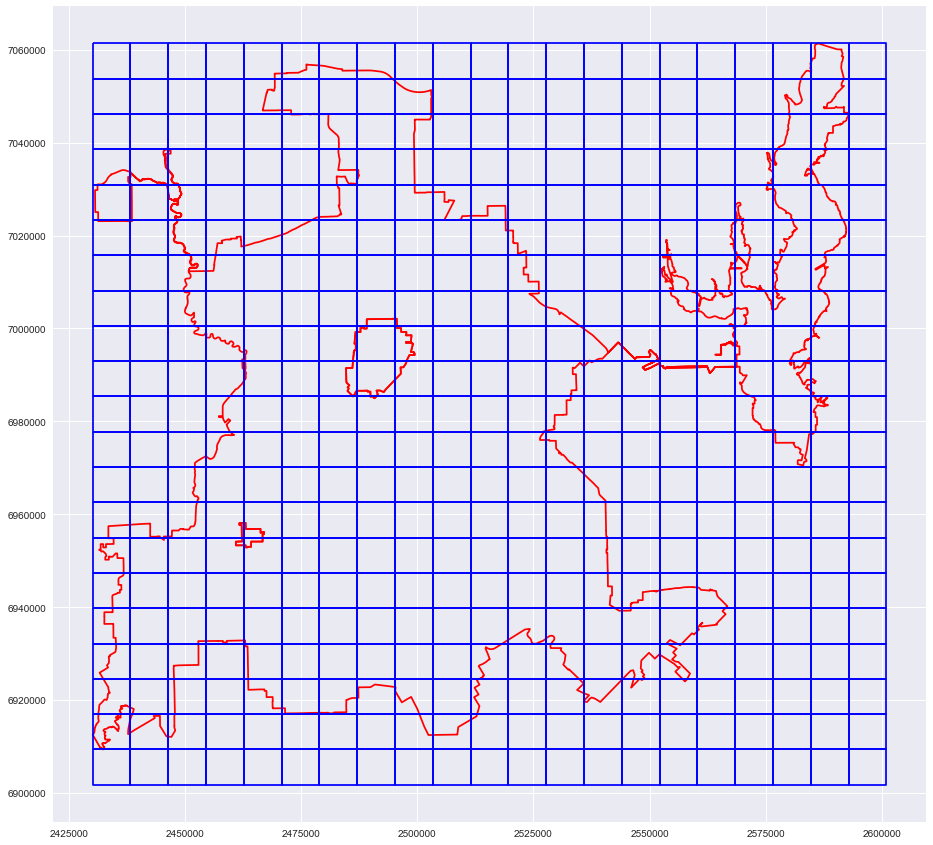

In [133]:
base = points.boundary.plot(color='red',figsize=(20, 15))
grid.boundary.plot(ax=base,color = 'blue',figsize=(20, 15));

/opt/anaconda3/lib/python3.7/site-packages/geopandas/base.py:48: UserWarning:

GeoSeries crs mismatch: epsg:4326 and None



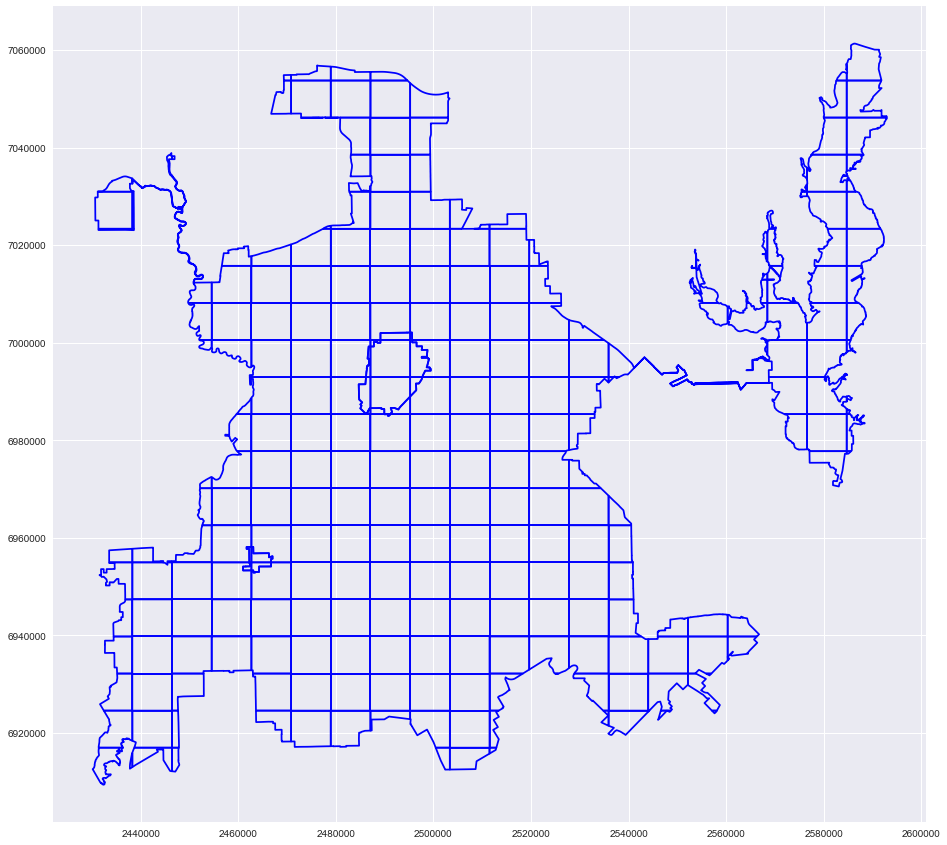

In [134]:
# trim the grid to to match the city borders
grid_trimmed = gpd.overlay(grid, points, how='intersection')
grid_trimmed.boundary.plot(color= 'blue',figsize=(20, 15))

In [135]:
# check number of groupings
grid_trimmed.shape

(276, 1)

In [143]:
# create geo points for each lat/long coordinate
crime_locations = [Point(xy) for xy in zip(data.long, data.lat)]
data['geometry'] = crime_locations
#data_loc_copy.drop(['lat','long'], axis = 1, inplace=True)

In [144]:
# convert dataframe to a geo-dataframe
data_gpd = gpd.GeoDataFrame(data, crs=crs, geometry=crime_locations)

In [145]:
# map each crime lat/long points to the index of the polygon that they fall within
from geopandas.tools import sjoin
data_final = sjoin(data_gpd, grid_trimmed, how='left',op="within")
data_final = data_final.rename(columns={'index_right': 'mapped_region'})

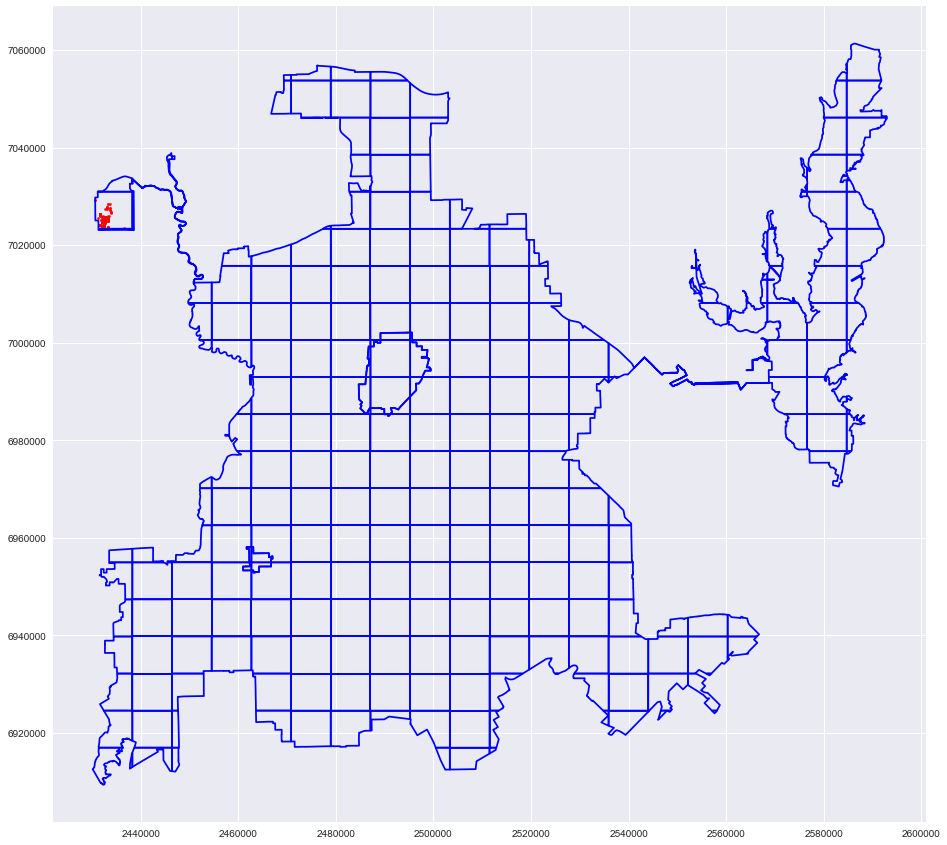

In [146]:
# check if mappings worked
subset_gpd = data_final.loc[(data_final['mapped_region'] == 1),:]

# plot all points that were tagged within index 1 polygon 
base = grid_trimmed.boundary.plot(color='blue',figsize=(20, 15))
subset_gpd.geometry.plot(ax=base,color='red',figsize=(20, 15),markersize=5)